### Homework 2: Geospatial Analysis EDS 296

In this assignment, you will perform some geospatial visualizations for a region of your choice.
The code constructed should be in Python, and follow a format similar to the tutorials we’ve
been working through in class. Use whatever section headings you like, so long as the tasks
below are included in the notebook!

The link to the [GitHub Repository](https://github.com/tommats00/CMIP6_AWS)

#### Part 1: 
Using the CMIP6 database hosted on Amazon Web Services, choose any two models you
like: use both their historical simulations and future projections from one of the four major
SSPs (ssp126, ssp245, ssp370, or ssp585). Provide a brief description of the models and
scenarios you chose to include.

#### Let's load the modules that will/might be used

In [1]:
# Load modules
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


We need to select two models and two scenarios (one of them being historical) for this exercise. Let's first Open the CMIP6 catalog to view the options that we have for our models

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [3]:
# Print the catalog to get a summary of its contents
catalog

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [4]:
# We are interested in viewing the different models
catalog.df.source_id.unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-LR',
       'ECMWF-IFS-HR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'CanESM5',
       'SAM0-UNICON', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-H', 'MRI-AGCM3-2-S',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

I am going to use the `AWI-CM-1-1-MR` and `EC-Earth3` models from this list. They are particularly good at simulating sea ice thickness, which is the variable I want to study for this exercise. The two scenarios I will be using are the `historical` and `SSP5-8.5`. I chose the latter because It represents a worst case scenario with the highest emissions. 

`AWI-CM-1-1-MR`: It is considered one of the most advanced `CMIP6` Arctic sea ice models. It has strong representation of ice dyanmics, focuses on the polar region, and has high resolution measurements. 

`EC-Earth3`: This model simulates Earth's climate and is great for studying the atmosphere, ocean, sea ice, land surface, and other biogeochecmical processes. It is great for studying past, present, and future projections which is why i wanted to use it. 

`Historical`: The historical scenario contains observed data from 1850 to 2014 with variables like greenhouse gases, aerosols, volcanic eruptions, land use change, etc. It is used as a benchmark to evaluate how well models simulate these past observations. 

`SSP5-8.5`: SSP stands for Shared Socioeconomic Pathway. This one in particular represents a worst case scenario, where we continue emissions at the current rate with no concern for reducing. This model is demonstrated from 2015-2100 and is used to determine future projections. 



#### Select Parameters for the model

In [5]:
# Specify search terms to query catalog for the two models
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['CMIP', 'ScenarioMIP'] 

# source_id: Two models for this exercise 
source_id = ['AWI-CM-1-1-MR', 'EC-Earth3']

# experiment_id: what experimental configuration do you want? Here we want historical and SSP585
experiment_ids = ['historical', 'ssp585']

# member_id: which ensemble member do you want? Here we want r1i1p1f1
member_id = ['r1i1p1f1']

# table_id: Monthly atmosphere data
table_id = 'SImon' 

# variable_id: Precipitation 
variable_id = 'sithick' 

We have the chosen parameters, let's now search through the catalog and store it as a dataframe

In [6]:
# Search catalog, store results
res = catalog.search(activity_id=activity_ids, 
                     source_id=source_id, 
                     experiment_id=experiment_ids, 
                     member_id=member_id, 
                     table_id=table_id, 
                     variable_id=variable_id)

# Turn results into a dataframe
res = res.df
res

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,SImon,sithick,gn,s3://cmip6-pds/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/hi...,NaN,20181218
1,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp585,r1i1p1f1,SImon,sithick,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/AWI/AWI-CM-1-...,NaN,20181218
2,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,SImon,sithick,gn,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20200918
3,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp585,r1i1p1f1,SImon,sithick,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/EC-Earth-Cons...,NaN,20200918


#### Choose region of interest
Since I am interested in Sea Ice Thickness, and my models specialize in the poles, I am going to use Alaska as my region of interest. This is a cold region with lots of snow and ice cover. From climate change, we would expect, and have already seen polar caps melting due warming. 

In [7]:
lat_min, lat_max = 50.03, 71.6925
lon_min, lon_max = -172.347846, -132.097822

### Choose two separate time periods, each 30-50 years in length

a. Map the average over each time period separately

b. Map the difference in the averages between the two time periods (note: make sure to label
which time period you subtracted from which!)

For both your sets of maps, display some relevant political/geographic boundaries overlaid
on the region: we saw some examples of how to do this using the Cartopy “feature” toolbox
in the mapping tutorials.

In [8]:
# Store historical AWI data
awi_historical = xr.open_zarr(res['zstore'][0], storage_options = {'anon':True})

# Store SSP585 AWI datta
awi_ssp = xr.open_zarr(res['zstore'][1], storage_options = {'anon':True})

# Store historical Earth3 data
ec_historical = xr.open_zarr(res['zstore'][2], storage_options = {'anon':True})

# Store SSP585 Earth3 data
ec_ssp = xr.open_zarr(res['zstore'][3], storage_options = {'anon':True})


In [9]:
# Concatenate the data
awi = xr.concat([awi_historical, awi_ssp], dim ='time')

ec = xr.concat([ec_historical, ec_ssp], dim='time')

Now that the data is in different `xarray`'s, we want to splice it into 30-50 year time periods and map it. We first need to convert the time as a `datttime64` type. 

In [10]:
# Convert both time variables to a datetime
awi['time'] = awi.time.astype('datetime64[ns]')

ec['time'] = ec.time.astype('datetime64[ns]')

I chose to do 1981 to 2010 and 2060 to 2100 because it is right on the end of the historical and SSP585 date ranges as historical ends at 2014 and SSP585 ends at 2100. This way we can see the difference in the most recent data we have (on a 30 year time scale) to the end time range of our projections. 

In [11]:
# Data for early period
awi_early = awi.sel(time=slice("1981-01-01", "2010-12-31"))
ec_early = ec.sel(time=slice("1981-01-01", "2010-12-31"))

# Data for later period
awi_late = awi.sel(time=slice("2060-01-01", "2100-12-31"))
ec_late = ec.sel(time=slice("2060-01-01", "2100-12-31"))

### Check units and coordinates are the same

In [12]:
print(awi_early.sithick.units)

print(ec_early.sithick.units)

m
m


In [13]:
# Check lat and lon values
print(f"Lat range: {awi_early.lat.min().values} to {awi_early.lat.max().values}")
print(f"Lon range: {awi_early.lon.min().values} to {awi_early.lon.max().values}")

Lat range: -78.5346757711801 to 89.8944937916176
Lon range: -179.99948431365 to 179.999695434874


In [14]:
# Check lat and lon values
print(f"Lat range: {ec_early.latitude.min().values} to {ec_early.latitude.max().values}")
print(f"Lon range: {ec_early.longitude.min().values} to {ec_early.longitude.max().values}")

Lat range: -78.57994842529297 to 89.74176788330078
Lon range: 0.0498046875 to 359.99493408203125


The longitudinal values for Earth3 are on a scale from 0 to 360 instead of -180 to 180. We will have to convert those at some point to properly plot.

### Map the average for each AWI time period

In [15]:
# Calculate mean for early time period
awi_early_mean = awi_early.mean(dim='time')

# Apply mask: keep only cells in Alaska region
awi_alaska_early = awi_early_mean.where(
    (awi_early_mean.lat >= lat_min) & (awi_early_mean.lat <= lat_max) &
    (awi_early_mean.lon >= lon_min) & (awi_early_mean.lon <= lon_max),
    drop=True  # drop values outside region
)

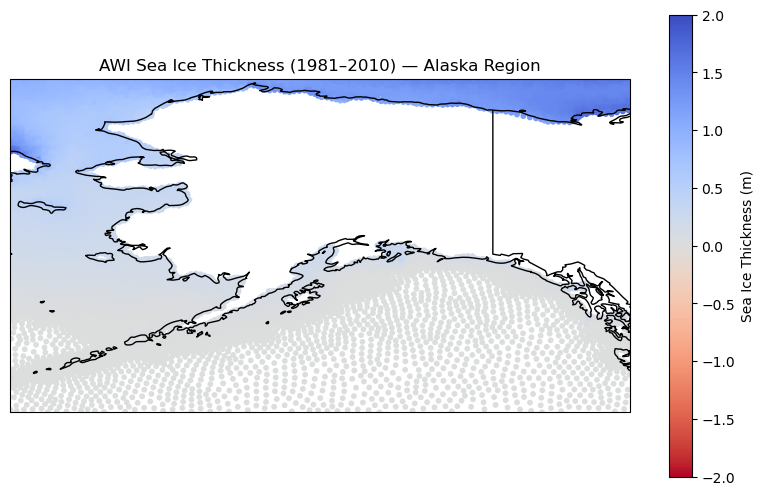

In [16]:
vmax=2
vmin= -vmax

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Scatterplot of data, pcolormesh was being difficult
sc = ax.scatter(
    awi_alaska_early.lon, awi_alaska_early.lat, 
    c=awi_alaska_early.sithick, 
    cmap='coolwarm_r', s=10,
    vmax=vmax, vmin=vmin,
    transform=ccrs.PlateCarree()
)

# Set labels
ax.set_title("AWI Sea Ice Thickness (1981–2010) — Alaska Region")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features and show
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(sc, ax=ax, label='Sea Ice Thickness (m)')
plt.show()

In [17]:
# Calculate mean for late time period
awi_late_mean = awi_late.mean(dim='time')

# Apply mask: keep only cells in Alaska region
awi_alaska_late = awi_late_mean.where(
    (awi_late_mean.lat >= lat_min) & (awi_late_mean.lat <= lat_max) &
    (awi_late_mean.lon >= lon_min) & (awi_late_mean.lon <= lon_max),
    drop=True  # drop values outside region
)

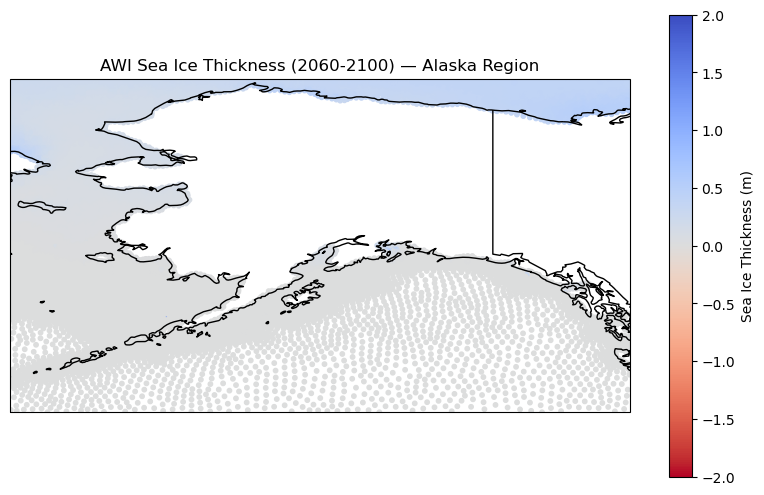

In [18]:
vmax=2
vmin=-vmax

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Scatterplot of data, pcolormesh was being difficult
sc = ax.scatter(
    awi_alaska_late.lon, awi_alaska_late.lat, 
    c=awi_alaska_late.sithick, 
    cmap='coolwarm_r', s=10,
    vmax=vmax, vmin=vmin,
    transform=ccrs.PlateCarree()
)

# Set labels
ax.set_title("AWI Sea Ice Thickness (2060-2100) — Alaska Region")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features and show
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(sc, ax=ax, label='Sea Ice Thickness (m)')
plt.show()

### Map the average for each Earth3 time period

In [19]:
# Calculate mean for early time period
ec_early_mean = ec_early.mean(dim='time')

# The longitudinal coordinates are from 0-360 so we need to 
#  convert to a our original longitude by adding 360
lon_min_360, lon_max_360 = lon_min + 360, lon_max + 360  # Alaska longitude in 0-360 format

# Apply mask: keep only cells in Alaska region
ec_alaska_early = ec_early_mean.where(
    (ec_early_mean.latitude >= lat_min) & (ec_early_mean.latitude <= lat_max) & 
    (ec_early_mean.longitude >= lon_min_360) & (ec_early_mean.longitude <= lon_max_360),
    drop=True  # drop values outside region
)

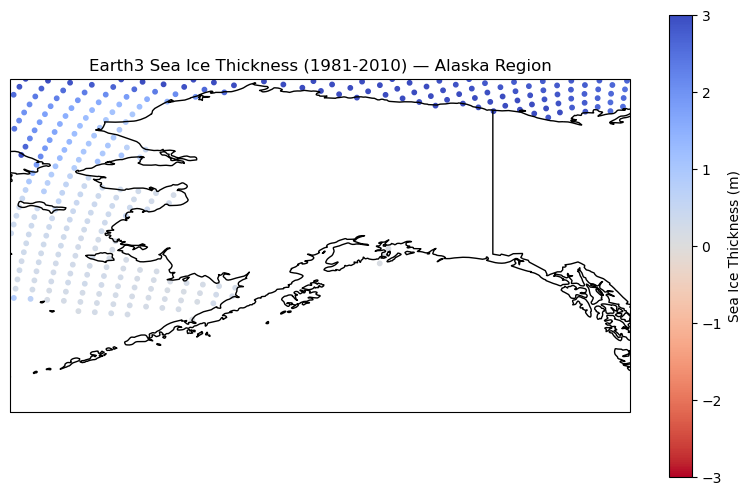

In [20]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the symmetric bounds manually
vmax = 3 
vmin = -vmax

# Scatterplot of the data, pcolormesh was giving me a hard time
sc = ax.scatter(
    ec_alaska_early.longitude, ec_alaska_early.latitude, 
    c=ec_alaska_early.sithick, 
    cmap='coolwarm_r', s=10,
    vmin=vmin, vmax=vmax,  # sets white at 0
    transform=ccrs.PlateCarree()
)

# Set labels
ax.set_title("Earth3 Sea Ice Thickness (1981-2010) — Alaska Region")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Set features and show
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(sc, ax=ax, label='Sea Ice Thickness (m)')
plt.show()

In [21]:
# Calculate mean for late time period
ec_late_mean = ec_late.mean(dim='time')

# Apply mask: keep only cells in Alaska region
ec_alaska_late = ec_late_mean.where(
    (ec_late_mean.latitude >= lat_min) & (ec_late_mean.latitude <= lat_max) & 
    (ec_late_mean.longitude >= lon_min_360) & (ec_late_mean.longitude <= lon_max_360),
    drop=True  # drop values outside region
)

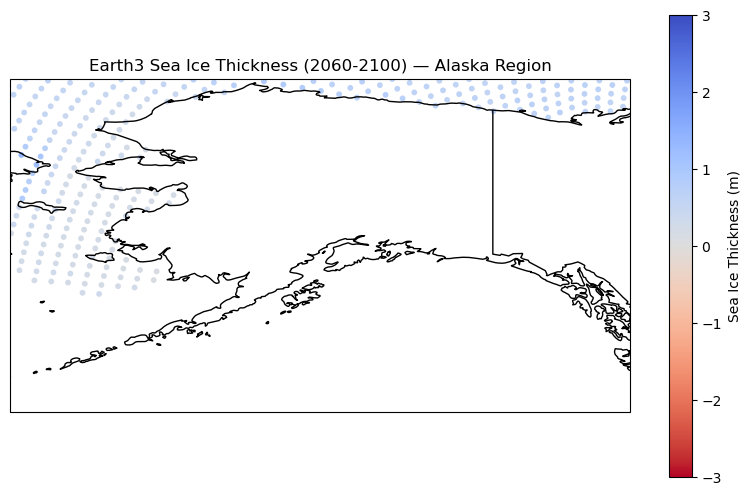

In [22]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the symmetric bounds manually
vmax = 3 
vmin = -vmax

# Scatterplot of the data, pcolormesh was giving me a hard time
sc = ax.scatter(
    ec_alaska_late.longitude, ec_alaska_late.latitude, 
    c=ec_alaska_late.sithick, 
    cmap='coolwarm_r', s=10,
    vmin=vmin, vmax=vmax,  # sets white at 0
    transform=ccrs.PlateCarree()
)

# Set labels
ax.set_title("Earth3 Sea Ice Thickness (2060-2100) — Alaska Region")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Set features and show
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(sc, ax=ax, label='Sea Ice Thickness (m)')
plt.show()

### Map the differences in the averages between the time periods

In [23]:
# Calculate differences
awi_diff = awi_late.mean(dim='time') - awi_early.mean(dim='time')
ec_diff = ec_late.mean(dim='time') - ec_early.mean(dim='time')

In [24]:
# Apply mask: keep only cells in Alaska region
awi_alaska = awi_diff.where(
    (awi_diff.lat >= lat_min) & (awi_diff.lat <= lat_max) &
    (awi_diff.lon >= lon_min) & (awi_diff.lon <= lon_max),
    drop=True  # drop values outside region
)

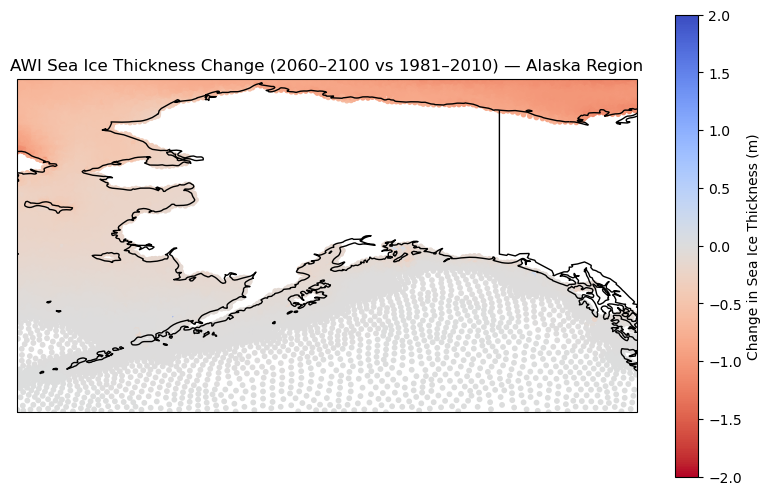

In [25]:
vmax = 2 
vmin = -vmax

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Scatterplot of data, pcolormesh was being difficult
sc = ax.scatter(
    awi_alaska.lon, awi_alaska.lat, 
    c=awi_alaska.sithick,
    vmax=vmax,vmin=vmin,
    cmap='coolwarm_r', s=10,
    transform=ccrs.PlateCarree()
)

# Set labels
ax.set_title("AWI Sea Ice Thickness Change (2060–2100 vs 1981–2010) — Alaska Region")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features and show
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(sc, ax=ax, label='Change in Sea Ice Thickness (m)')
plt.show()


In [26]:
# Apply mask: keep only cells in Alaska region
ec_alaska = ec_diff.where(
    (ec_diff.latitude >= lat_min) & (ec_diff.latitude <= lat_max) & 
    (ec_diff.longitude >= lon_min_360) & (ec_diff.longitude <= lon_max_360),
    drop=True  # drop values outside region
)

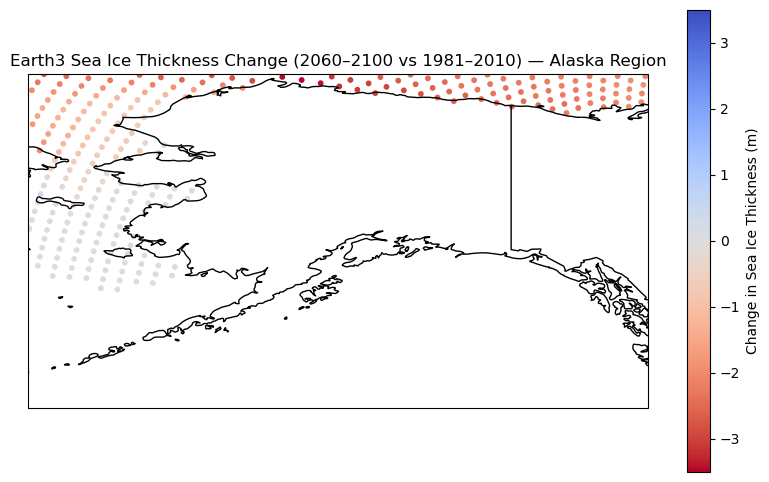

In [27]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the symmetric bounds manually
vmax = 3.5 
vmin = -vmax

# Scatterplot of the data, pcolormesh was giving me a hard time
sc = ax.scatter(
    ec_alaska.longitude, ec_alaska.latitude, 
    c=ec_alaska.sithick, 
    cmap='coolwarm_r', s=10,
    vmin=vmin, vmax=vmax,  # sets white at 0
    transform=ccrs.PlateCarree()
)

# Set labels
ax.set_title("Earth3 Sea Ice Thickness Change (2060–2100 vs 1981–2010) — Alaska Region")
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Set features and show
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.colorbar(sc, ax=ax, label='Change in Sea Ice Thickness (m)')
plt.show()


### Conclusions

From the plots, we see a large decrease of sea ice thickness from 1981-2010 to 2060-2100. Both models indicate a loss of at least a meter in sea ice thickness around the coast of Alaska. The Earth3 model indicates even higher loss of sea ice with up to 3 meters in some locations. The models for the later time period (2060 -2100) displays that there are many areas close to having 0 seac ice thickness. This means that it would be completely melted. Sea ice is very crucial to the species that live within the artic region. It provides habitat, breeing grounds, hunting areas, and more. Without it, species are vulnerable to extinction. 

It should be noted that these models are using the SSP585 scenario, which is considered the worst case scenario, where humans continue emitted greenhouse gases at a very high rate. These models are important to display this information, so that we understand the impact we have on our planet. From understanding these models, we can head towards a better path that reduces the amount of greenhouse gases that we put out into the atmosphere. 